# TRANSFER LEARNING EXEMPLIFIED!

## import packages and download data

In [ ]:
import os
from skimage import color
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set()

In [ ]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O ./cats_and_dogs_filtered.zip

--2020-09-27 22:42:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.195.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   119MB/s    in 0.6s    

2020-09-27 22:42:29 (119 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
dataset_path = "./cats_and_dogs_filtered.zip"

In [ ]:
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")

In [ ]:
zip_object.extractall()

In [ ]:
zip_object.close()

In [ ]:
dataset_path_new = "./cats_and_dogs_filtered/"

## eda

(374, 500, 3)
The dimensions of the image are 374 pixels width and 500 pixels height, three single color channel
The maximum pixel value is 255 and the minimum is 0
The mean value of the pixels is 119.7826 and the standard deviation is 82.3396

(375, 499, 3)
The dimensions of the image are 375 pixels width and 499 pixels height, three single color channel
The maximum pixel value is 255 and the minimum is 0
The mean value of the pixels is 116.7904 and the standard deviation is 50.9613



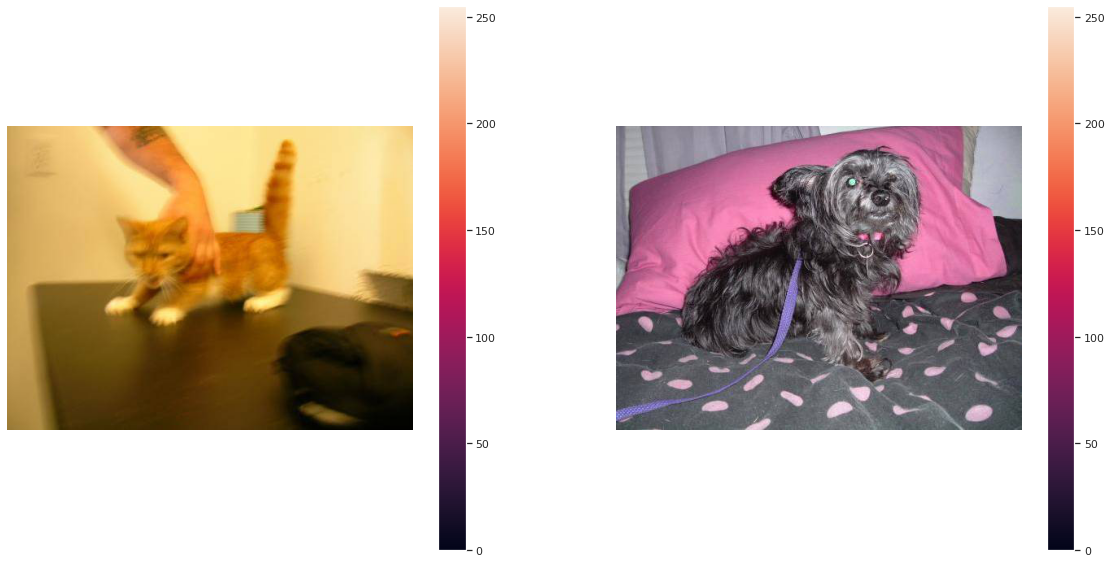

In [ ]:
img_dir = dataset_path_new + '/train/'
cat = 'cats/cat.0.jpg'
dog = 'dogs/dog.0.jpg'
images = [cat, dog]
plt.figure(figsize=(20,10))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    img = plt.imread(os.path.join(img_dir, images[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.colorbar()
    print(img.shape)
    print(f"The dimensions of the image are {img.shape[0]} pixels width and {img.shape[1]} pixels height, three single color channel")
    print(f"The maximum pixel value is {img.max()} and the minimum is {img.min():}")
    print(f"The mean value of the pixels is {img.mean():.4f} and the standard deviation is {img.std():.4f}")
    print()

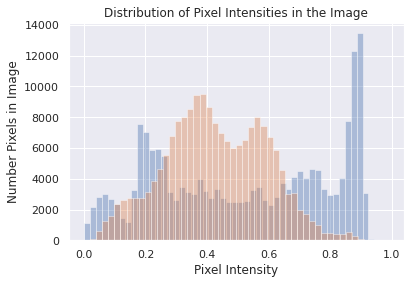

In [ ]:
for i in range(2):
    rgb_img = plt.imread(os.path.join(img_dir, images[i]))
    grayscale_img = color.rgb2gray(rgb_img)
    sns.distplot(grayscale_img.ravel(), kde=False)
    plt.title('Distribution of Pixel Intensities in the Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Number Pixels in Image')

## data preparation

In [ ]:
train_dir = os.path.join(dataset_path_new, "train")
validation_dir = os.path.join(dataset_path_new, "validation")

In [ ]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128,128), 
                                                     batch_size=128, class_mode="binary")

Found 2000 images belonging to 2 classes.


In [ ]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(128,128), 
                                                     batch_size=128, class_mode="binary")

Found 1000 images belonging to 2 classes.


## modelling

In [ ]:
IMG_SHAPE = (128, 128, 3)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, 
                                            weights="imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

<tf.Tensor 'out_relu/Relu6:0' shape=(None, 4, 4, 1280) dtype=float32>

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [ ]:
prediction_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(global_average_layer)

In [ ]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator, epochs=5, validation_data=valid_generator)

Epoch 1/5
16/16 [==============================] - 39s 2s/step - loss: 0.3821 - accuracy: 0.8570 - val_loss: 0.3594 - val_accuracy: 0.8720
Epoch 2/5
16/16 [==============================] - 38s 2s/step - loss: 0.3419 - accuracy: 0.8740 - val_loss: 0.3237 - val_accuracy: 0.8860
Epoch 3/5
16/16 [==============================] - 38s 2s/step - loss: 0.3081 - accuracy: 0.8875 - val_loss: 0.2938 - val_accuracy: 0.8950
Epoch 4/5
16/16 [==============================] - 39s 2s/step - loss: 0.2800 - accuracy: 0.9010 - val_loss: 0.2689 - val_accuracy: 0.9070
Epoch 5/5
16/16 [==============================] - 38s 2s/step - loss: 0.2571 - accuracy: 0.9115 - val_loss: 0.2483 - val_accuracy: 0.9180


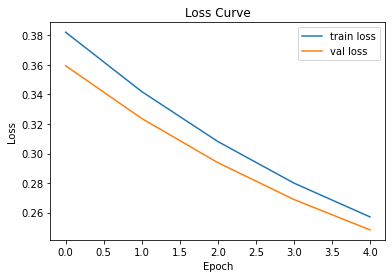

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss Curve')
plt.show()

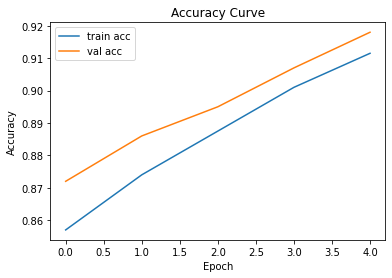

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy Curve')
plt.show()

## can the model performance improve via fine-tuning?

In [ ]:
base_model.trainable = True

In [ ]:
len(base_model.layers)

155

In [ ]:
fine_tune_at = 120

In [ ]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator, epochs=3, validation_data=valid_generator)

Epoch 1/3
16/16 [==============================] - 53s 3s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.9690
Epoch 2/3
16/16 [==============================] - 53s 3s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1098 - val_accuracy: 0.9670
Epoch 3/3
16/16 [==============================] - 53s 3s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1500 - val_accuracy: 0.9620


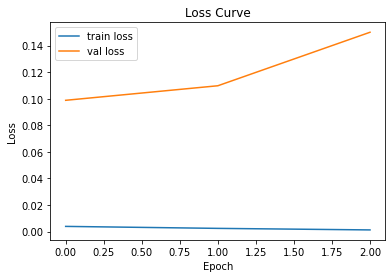

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss Curve')
plt.show()

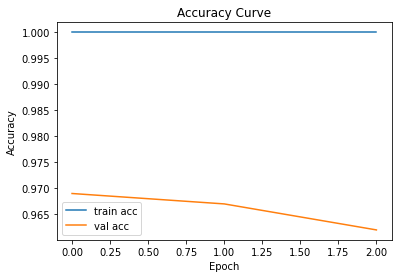

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy Curve')
plt.show()